# Trans-effect validation: comparison with FACS screens

In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import adjustText

from DE_analysis_utils import *

In [2]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42  # Output Type 3 (Type 3) fonts contain vectors that remain editable in programs like Illustrator
plt.rcParams['ps.fonttype'] = 42  # Same as above but for PostScript files
matplotlib.rcParams['font.family'] = 'Arial'

In [3]:
# Read color palette
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)


## Read DE analysis outputs

In [4]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final/'
if os.path.exists(datadir):
    pass
else:
    datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'

In [5]:
adata_de = anndata.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [6]:
# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter out genes with no on-target KD effects
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
# ontarget_genelist = de_summary_stats[de_summary_stats.ontarget_effect_category=='on-target KD'].target_name.unique().tolist()
# adata_de = adata_de[adata_de.obs.target_contrast_gene_name.isin(ontarget_genelist)].copy()
#adata_de = adata_de[adata_de.obs.n_cells_target>=50].copy()
adata_de.obs['target_contrast'].nunique()

11526

## Process FACS screen results

In [7]:
def get_mageck_pval(df, lfc_col='neg|lfc', pos_fdr_col='pos|fdr', neg_fdr_col='neg|fdr'):
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    result_df['fdr'] = np.nan
    
    for idx, row in result_df.iterrows():
        log_fc = row[lfc_col]
        
        # Select the appropriate fdr based on the direction of log_fc
        if log_fc > 0:
            fdr = row[pos_fdr_col]
        elif log_fc < 0:
            fdr = row[neg_fdr_col]
        else:
            # If log_fc is exactly 0, standard error is undefined
            continue
        
        if 0 <= fdr < 1:
            result_df.at[idx, 'fdr'] = fdr
    
    return result_df

In [8]:
keep_mageck_columns = ['perturbed_gene_name', 'fdr', 'lfc', 'phenotype', 'perturbation_type', 'downstream_gene']

In [9]:
Schmidt2022_data = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv', index_col=0)
Schmidt2022_data['downstream_gene'] = np.where(Schmidt2022_data['phenotype'] == 'CD4+ IL2', 'IL2', 'IFNG')
Schmidt2022_data['perturbation_type'] = 'CRISPRi'
Schmidt2022_data = get_mageck_pval(Schmidt2022_data)
Schmidt2022_data = Schmidt2022_data.rename({'id':'perturbed_gene_name', 'neg|lfc':'lfc'}, axis=1)[keep_mageck_columns].copy()
Schmidt2022_data.head()

,perturbed_gene_name,fdr,lfc,phenotype,perturbation_type,downstream_gene
0,VAV1,0.00015,-2.9160,CD4+ IL2,CRISPRi,IL2
1,LCP2,0.00015,-1.8811,CD4+ IL2,CRISPRi,IL2
2,CD3G,0.00015,-2.6665,CD4+ IL2,CRISPRi,IL2
3,IL2,0.00015,-2.6101,CD4+ IL2,CRISPRi,IL2
4,CD3D,0.00015,-2.4943,CD4+ IL2,CRISPRi,IL2


In [10]:
# Supplementary table 8
FOXP3_data = pd.read_csv('../../metadata/Umhoefer2025_FOXP3_Teff.csv')
FOXP3_data['perturbation_type'] = 'CRISPRn'
FOXP3_data['phenotype'] = 'CD4+ FOXP3'
FOXP3_data['downstream_gene'] = 'FOXP3'
FOXP3_data = get_mageck_pval(FOXP3_data)
FOXP3_data = FOXP3_data.rename({'id':'perturbed_gene_name', 'neg|lfc':'lfc'}, axis=1)[keep_mageck_columns]
FOXP3_data['lfc'] = FOXP3_data['lfc'] * -1 # Somehow the lfc is flipped
FOXP3_data.head(10)

,perturbed_gene_name,fdr,lfc,phenotype,perturbation_type,downstream_gene
0,Non-Targeting,NaN,-0.00000,CD4+ FOXP3,CRISPRn,FOXP3
1,FOXO1,0.00045,-1.82020,CD4+ FOXP3,CRISPRn,FOXP3
2,PTEN,0.00045,-1.13060,CD4+ FOXP3,CRISPRn,FOXP3
3,GATA3,0.00045,-1.39490,CD4+ FOXP3,CRISPRn,FOXP3
4,NFKB2,0.00045,-0.97018,CD4+ FOXP3,CRISPRn,FOXP3
5,STAT5A,0.00045,-1.00310,CD4+ FOXP3,CRISPRn,FOXP3
6,ATXN7L3,0.00045,-0.99349,CD4+ FOXP3,CRISPRn,FOXP3
7,FOXP3,0.00045,-1.66540,CD4+ FOXP3,CRISPRn,FOXP3
8,STAT5B,0.00045,-0.95471,CD4+ FOXP3,CRISPRn,FOXP3
9,IKZF1,0.00045,-0.92887,CD4+ FOXP3,CRISPRn,FOXP3


In [11]:
# Arce 2025 - Supplementary table 1
Arce_IL2RA_data = pd.read_csv('../../metadata/Arce2025_Screen.csv')
# Melt the dataframe to convert columns with suffixes into a longer format
# Identify columns with suffixes like '.Resting_Teff', '.Resting_Treg'
suffixes = [col.split('.')[-1] for col in Arce_IL2RA_data.columns if '.' in col]
suffixes = list(set(suffixes))  # Get unique suffixes

# Create a list to store melted dataframes for each suffix
melted_dfs = []

for suffix in suffixes:
    # Get columns for this suffix
    suffix_cols = [col for col in Arce_IL2RA_data.columns if col.endswith('.' + suffix)]
    # Get base columns (without suffix)
    base_cols = [col.split('.')[0] for col in suffix_cols]
    
    # Create a subset with id and columns for this suffix
    subset = Arce_IL2RA_data[['id'] + suffix_cols].copy()
    # Rename columns to remove suffix
    rename_dict = {suffix_cols[i]: base_cols[i] for i in range(len(suffix_cols))}
    subset = subset.rename(columns=rename_dict)
    # Add condition column
    subset['phenotype'] = suffix
    
    melted_dfs.append(subset)

# Combine all melted dataframes
long_Arce_data = pd.concat(melted_dfs, ignore_index=True)
long_Arce_data = long_Arce_data[long_Arce_data.phenotype!='Resting_Treg'].copy() # Not considering resting Treg
long_Arce_data['phenotype'] = long_Arce_data['phenotype'].astype(str) + '_IL2RA'
long_Arce_data['downstream_gene'] = 'IL2RA'
long_Arce_data['perturbation_type'] = 'CRISPRn'
long_Arce_data = get_mageck_pval(long_Arce_data)
long_Arce_data = long_Arce_data.rename({'id':'perturbed_gene_name', 'neg|lfc':'lfc'}, axis=1)[keep_mageck_columns]
long_Arce_data['lfc'] = long_Arce_data['lfc'] * -1 # Somehow the effect size is flipped
long_Arce_data.head()

,perturbed_gene_name,fdr,lfc,phenotype,perturbation_type,downstream_gene
0,STAT5B,0.000354,-2.8575,Resting_Teff_IL2RA,CRISPRn,IL2RA
1,IL2RA,0.000354,-3.1775,Resting_Teff_IL2RA,CRISPRn,IL2RA
2,PTEN,0.000354,-1.4230,Resting_Teff_IL2RA,CRISPRn,IL2RA
3,STAT5A,0.000354,-1.7202,Resting_Teff_IL2RA,CRISPRn,IL2RA
4,FOXP1,0.000354,-1.1629,Resting_Teff_IL2RA,CRISPRn,IL2RA


In [12]:
# Concatenate all FACS tables into one dataframe
# First, add a source column to each dataframe to track the origin
Schmidt2022_data['dataset'] = 'Schmidt2022'
FOXP3_data['dataset'] = 'Umhoefer2025'
long_Arce_data['dataset'] = 'Arce2025'

# Concatenate all dataframes
all_FACS_data = pd.concat([
    Schmidt2022_data,
    FOXP3_data,
    long_Arce_data
], ignore_index=True)

# Display the first few rows to verify the concatenation
print(f"Combined FACS data shape: {all_FACS_data.shape}")
all_FACS_data.head()

Combined FACS data shape: (41931, 7)


,perturbed_gene_name,fdr,lfc,phenotype,perturbation_type,downstream_gene,dataset
0,VAV1,0.00015,-2.9160,CD4+ IL2,CRISPRi,IL2,Schmidt2022
1,LCP2,0.00015,-1.8811,CD4+ IL2,CRISPRi,IL2,Schmidt2022
2,CD3G,0.00015,-2.6665,CD4+ IL2,CRISPRi,IL2,Schmidt2022
3,IL2,0.00015,-2.6101,CD4+ IL2,CRISPRi,IL2,Schmidt2022
4,CD3D,0.00015,-2.4943,CD4+ IL2,CRISPRi,IL2,Schmidt2022


In [13]:
def pick_similar_downstream_gene(summary_stats, target_gene, rank_diff=10):
    """
    Get control genes with similar baseMean with target genes
    """
    summary_stats['baseMean'] = summary_stats['baseMean'].fillna(0)
    summary_stats['baseMean_rank'] = summary_stats.baseMean.rank()
    target_gene_rank = summary_stats[summary_stats['target_name']==target_gene]['baseMean_rank'].values[0]
    if (target_gene_rank<=len(summary_stats) - rank_diff)&(target_gene_rank>=rank_diff):
        genes_with_similar_baseMean = summary_stats[(summary_stats['baseMean_rank']>=target_gene_rank-rank_diff)&(summary_stats['baseMean_rank']<=target_gene_rank+rank_diff)].target_name.tolist()
    elif target_gene_rank>len(summary_stats) - rank_diff:
        genes_with_similar_baseMean = summary_stats[summary_stats['baseMean_rank']>=target_gene_rank-2*rank_diff].target_name.tolist()
    else:
        genes_with_similar_baseMean = summary_stats[summary_stats['baseMean_rank']<=target_gene_rank+2*rank_diff].target_name.tolist()
    return genes_with_similar_baseMean

In [ ]:
def comparison_r(all_FACS_data, adata_de, target_gene, phenotype, condition, rank_diff=10, facs_fdr_threshold=0.05, bootstrap_times=5, bootstrap_frac=0.7):
    """
    Compare gwt zscore with facs lfc with bootstrap
    """
    # Get FACS data
    mask = (all_FACS_data.phenotype==phenotype) & (all_FACS_data.fdr < facs_fdr_threshold)
    facs_lfc_sig = all_FACS_data[mask].copy().set_index('perturbed_gene_name')
    
    # Get common genes between datasets and has on-target effect
    common_sig_perturbations = set(adata_de[adata_de.obs.culture_condition==condition].obs.target_contrast_gene_name) \
    & set(facs_lfc_sig.index) \
    #& set(de_summary_stats[(de_summary_stats.condition==condition)&(de_summary_stats.ontarget_significant==True)].target_name)
    common_sig_perturbations = np.array(list(common_sig_perturbations))
    print(phenotype, condition, len(common_sig_perturbations))
    
    # Get control genes with similar baseMean to target gene
    downstream_gene = pick_similar_downstream_gene(de_summary_stats[(de_summary_stats.condition==condition)&(de_summary_stats.target_name.isin(adata_de.var.gene_name))].copy(),
                                                   target_gene, rank_diff=rank_diff)
    
    np.random.seed(42)
    bootstrap_seed = np.random.randint(1000, size=bootstrap_times)
    
    # Create two square dataframes for r and p values
    target_corr_r = pd.DataFrame(index=bootstrap_seed, columns=downstream_gene)
    target_corr_p = pd.DataFrame(index=bootstrap_seed, columns=downstream_gene)
    
    # Calculate correlations between all pairs of targets
    for seed in bootstrap_seed:
        # bootstrap
        mask = np.full(len(common_sig_perturbations), True, dtype=bool)
        rng = np.random.default_rng(seed)
        n_to_switch = int(len(common_sig_perturbations) * (1 - bootstrap_frac))
        true_indices = np.where(mask)[0]
        indices_to_switch = rng.choice(true_indices, size=n_to_switch, replace=False)
        mask[indices_to_switch] = False
        common_sig_perturbations_subset = common_sig_perturbations[mask]
    
        # Get gwt zscore and facs zscore
        subset_mask = (adata_de.obs['culture_condition'] == condition) & (adata_de.obs['target_contrast_gene_name'].isin(common_sig_perturbations_subset))
        gwt_zscore = sc.get.obs_df(adata_de[subset_mask], downstream_gene, gene_symbols='gene_name', layer='zscore')
        gwt_zscore.index = adata_de.obs.loc[gwt_zscore.index, 'target_contrast_gene_name']
        for gene in downstream_gene:
            r, p = scipy.stats.pearsonr(
                gwt_zscore.loc[common_sig_perturbations_subset, gene].fillna(0),
                facs_lfc_sig.loc[common_sig_perturbations_subset, 'lfc']
            )
            # Store correlation and p-value in separate matrices
            target_corr_r.loc[seed, gene] = r
            target_corr_p.loc[seed, gene] = p
    
    melted_df = target_corr_r.melt(var_name='source_column', value_name='correlation')
    result_df = melted_df[['correlation']].copy()
    result_df['matched_target'] = 'Mismatched'
    result_df.loc[melted_df['source_column']==target_gene, 'matched_target'] = 'Matched'
    #result_df['matched_target'] = melted_df['source_column']==target_gene
    result_df['condition'] = condition
    result_df['phenotype'] = phenotype
    
    return result_df

In [34]:
result_df_all = pd.DataFrame(columns=['correlation', 'matched_target', 'condition', 'phenotype', 'perturbation_type', 'dataset', 'downstream_gene']) 
for _, row in all_FACS_data[['phenotype', 'perturbation_type', 'dataset', 'downstream_gene']].drop_duplicates().iterrows():
    for condition in ['Rest', 'Stim8hr', 'Stim48hr']:
        result_df = comparison_r(all_FACS_data, adata_de, row.downstream_gene, row.phenotype, condition, rank_diff=20, bootstrap_times=100)
        result_df['perturbation_type'] = row.perturbation_type
        result_df['dataset'] = row.dataset
        result_df['downstream_gene'] = row.downstream_gene
        result_df_all = pd.concat([result_df_all, result_df])

result_df_all['combination'] = result_df_all.condition.astype(str) + '\n' + result_df_all.matched_target.astype(str)

CD4+ IL2 Rest 212
CD4+ IL2 Stim8hr 218
CD4+ IL2 Stim48hr 214
CD8+ IFNG Rest 253
CD8+ IFNG Stim8hr 262
CD8+ IFNG Stim48hr 255
CD4+ FOXP3 Rest 34
CD4+ FOXP3 Stim8hr 35
CD4+ FOXP3 Stim48hr 35
Stimulated_Teff_IL2RA Rest 37
Stimulated_Teff_IL2RA Stim8hr 38
Stimulated_Teff_IL2RA Stim48hr 38
Resting_Teff_IL2RA Rest 52
Resting_Teff_IL2RA Stim8hr 55
Resting_Teff_IL2RA Stim48hr 55


In [35]:
result_df_all.combination.unique()

array(['Rest\nMismatched', 'Rest\nMatched', 'Stim8hr\nMismatched',
       'Stim8hr\nMatched', 'Stim48hr\nMismatched', 'Stim48hr\nMatched'],
      dtype=object)

In [ ]:
# Set figure size
fig, ax = plt.subplots(figsize=(12.5, 9))

sns.barplot(result_df_all, x='phenotype', y='correlation', hue='combination',
            palette={'Rest\nMatched':palettes['culture_condition']['Rest'],
                     'Stim8hr\nMatched':palettes['culture_condition']['Stim8hr'],
                     'Stim48hr\nMatched':palettes['culture_condition']['Stim48hr'],
                     'Rest\nMismatched':'#d9d9d9',
                     'Stim8hr\nMismatched':'#bdbdbd',
                     'Stim48hr\nMismatched':'#969696'},
            hue_order=['Rest\nMatched',
                       'Stim8hr\nMatched',
                       'Stim48hr\nMatched',
                       'Rest\nMismatched',
                       'Stim8hr\nMismatched',
                       'Stim48hr\nMismatched'],
            ax=ax
            )

# Increase font sizes
plt.rcParams.update({'font.size': 18})
ax.tick_params(labelsize=18)
ax.set_xticklabels(['Schmidt 2022\nCD4+ IL-2\nStim10hr',
                   'Schmidt 2022\nCD8+ IFNG\nStim10hr',
                   'Umhoefer 2025\nCD4+ FOXP3\nStim48hr',
                   'Arce 2025\nCD4+ IL2RA\nStim72hr',
                   'Arce 2025\nCD4+ IL2RA\nRest'], fontsize=16)
ax.set_xlabel('FACS screening dataset', fontsize=18)
ax.set_ylabel('DE LFC Pearson R\n(GW perturb-seq vs FACS screening)', fontsize=20)
ax.set_ylim([-0.1,0.8])

# Move legend outside and rename labels
ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',
         facecolor='white', frameon=False, 
         fontsize=18)

sns.despine()

plt.tight_layout()

plt.savefig('results/FACScomparison_summary_barplot.png')
plt.savefig('results/FACScomparison_summary_barplot.pdf')

In [19]:
result_df_all['matched_target'] = np.where(result_df_all['matched_target'] == 'Mismatched', 'Random downstream gene', 'Matched downstream gene')
result_df_all['combination'] = result_df_all.condition.astype(str) + '\n' + result_df_all.matched_target.astype(str)

In [ ]:
# Set figure size
fig, ax = plt.subplots(figsize=(14.5, 7))
sns.barplot(result_df_all, x='phenotype', y='correlation', hue='combination',
            palette={'Rest\nMatched downstream gene':palettes['culture_condition']['Rest'],
                     'Stim8hr\nMatched downstream gene':palettes['culture_condition']['Stim8hr'],
                     'Stim48hr\nMatched downstream gene':palettes['culture_condition']['Stim48hr'],
                     'Rest\nRandom downstream gene':'#d9d9d9',
                     'Stim8hr\nRandom downstream gene':'#bdbdbd',
                     'Stim48hr\nRandom downstream gene':'#969696'},
            hue_order=['Rest\nMatched downstream gene',
                       'Rest\nRandom downstream gene',
                       'Stim8hr\nMatched downstream gene',
                       'Stim8hr\nRandom downstream gene',
                       'Stim48hr\nMatched downstream gene',
                       'Stim48hr\nRandom downstream gene'],
            ax=ax
            )

# Increase font sizes
plt.rcParams.update({'font.size': 18})
ax.tick_params(labelsize=18)
ax.set_xticklabels(['Schmidt 2022\nCD4+ IL-2\nStim10hr',
                   'Schmidt 2022\nCD8+ IFNG\nStim10hr',
                   'Umhoefer 2025\nCD4+ FOXP3\nStim48hr',
                   'Arce 2025\nCD4+ IL2RA\nStim72hr',
                   'Arce 2025\nCD4+ IL2RA\nRest',
                   ], fontsize=16)
ax.set_xlabel('FACS screening dataset', fontsize=18)
ax.set_ylabel('DE LFC Pearson R\n(GW perturb-seq vs FACS screening)', fontsize=20)
ax.set_ylim([-0.1,0.8])


# Move legend outside and rename labels
ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',
         facecolor='white', frameon=False, 
         fontsize=18)

sns.despine()

plt.tight_layout()

plt.savefig('results/FACScomparison_summary_barplot_v2.png')
plt.savefig('results/FACScomparison_summary_barplot_v2.pdf')

In [14]:
all_FACS_data.phenotype.unique()

array(['CD4+ IL2', 'CD8+ IFNG', 'CD4+ FOXP3', 'Resting_Teff_IL2RA',
       'Stimulated_Teff_IL2RA'], dtype=object)

In [15]:
phenotype = 'CD4+ IL2'
condition = 'Stim8hr'
target = 'IL2'

# Get FACS data
mask = (all_FACS_data.phenotype==phenotype) & (all_FACS_data.fdr < 0.05)
facs_lfc_sig = all_FACS_data[mask].copy().set_index('perturbed_gene_name')

# Get common genes between datasets and has on-target effect
common_sig_perturbations = set(adata_de[adata_de.obs.culture_condition==condition].obs.target_contrast_gene_name) \
& set(facs_lfc_sig.index) \
#& set(de_summary_stats[(de_summary_stats.condition==condition)&(de_summary_stats.ontarget_significant==True)].target_name)
common_sig_perturbations = np.array(list(common_sig_perturbations))

# Get FACS data
mask = (all_FACS_data.phenotype==phenotype)
facs_lfc_all = all_FACS_data[mask].copy().set_index('perturbed_gene_name')
# Get common genes between datasets and has on-target effect
common_perturbations = set(adata_de[adata_de.obs.culture_condition==condition].obs.target_contrast_gene_name) \
& set(facs_lfc_all.index) \
#& set(de_summary_stats[de_summary_stats.condition==condition].target_name)
common_perturbations = np.array(list(common_perturbations))

# Get GWT data
gwt_zscore = pd.DataFrame(data=adata_de[adata_de.obs.culture_condition==condition, adata_de.var.gene_name==target].layers['zscore'],
                          index=adata_de[adata_de.obs.culture_condition==condition].obs.target_contrast_gene_name,
                          columns=[target])

In [16]:
pl_df = pd.merge(facs_lfc_all, gwt_zscore, left_index=True, right_index=True)
#pl_df = pl_df.dropna()
corr_all, p_value = scipy.stats.pearsonr(pl_df['lfc'], pl_df[target])
corr_sig, p_value_sig = scipy.stats.pearsonr(pl_df[pl_df.fdr<0.05]['lfc'], pl_df[pl_df.fdr<0.05][target])

In [36]:
pl_df

,fdr,lfc,phenotype,perturbation_type,downstream_gene,dataset,IL2
VAV1,0.000150,-2.91600,CD4+ IL2,CRISPRi,IL2,Schmidt2022,-4.599094
LCP2,0.000150,-1.88110,CD4+ IL2,CRISPRi,IL2,Schmidt2022,-6.122531
CD3G,0.000150,-2.66650,CD4+ IL2,CRISPRi,IL2,Schmidt2022,-6.505076
IL2,0.000150,-2.61010,CD4+ IL2,CRISPRi,IL2,Schmidt2022,-6.003232
CD3D,0.000150,-2.49430,CD4+ IL2,CRISPRi,IL2,Schmidt2022,-5.496507
...,...,...,...,...,...,...,...
SLAMF6,0.000048,0.94307,CD4+ IL2,CRISPRi,IL2,Schmidt2022,0.977242
DHODH,0.000048,0.56468,CD4+ IL2,CRISPRi,IL2,Schmidt2022,1.162815
CD5,0.000048,1.30050,CD4+ IL2,CRISPRi,IL2,Schmidt2022,0.694892
MAP4K1,0.000048,0.95836,CD4+ IL2,CRISPRi,IL2,Schmidt2022,0.420263


In [42]:
target

'IL2'

In [41]:
gene

fdr                      0.00015
lfc                       -2.916
phenotype               CD4+ IL2
perturbation_type        CRISPRi
downstream_gene              IL2
dataset              Schmidt2022
IL2                    -4.599094
Name: VAV1, dtype: object

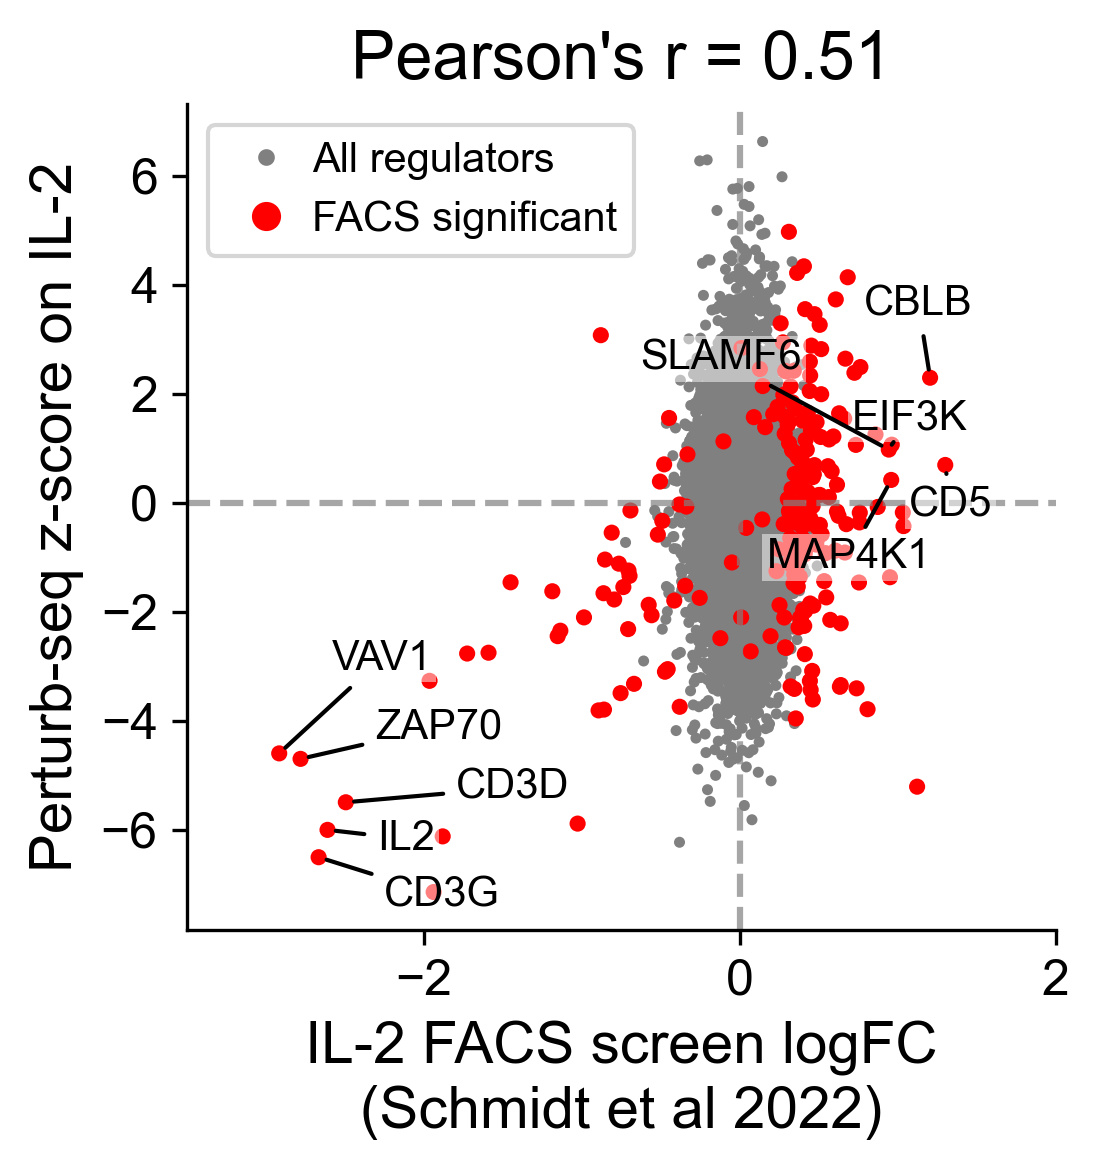

In [153]:
fig, ax = plt.subplots(figsize=(4.2, 4))
    
# Add dotted lines at x=0 and y=0
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    
# Plot non-significant points first
sns.scatterplot(data=pl_df, 
                x='lfc', y=target, 
                color='gray', edgecolor='none', s=7, 
                label=f'All regulators (n={len(pl_df)}) - r = {corr_all:.2f}, p = {p_value:.2e}',
                ax=ax)

# Plot significant points on top with different color
sns.scatterplot(data=pl_df[pl_df.fdr<0.05], 
                x='lfc', y=target, 
                color='red', edgecolor='none', s=15, 
                label=f'FACS significant (n={pl_df[pl_df.fdr<0.05]}) - r = {corr_sig:.2f}, p = {p_value_sig:.2e}' if not np.isnan(corr_sig) else 'Significant genes: insufficient data',
                ax=ax)

# Set axis labels with dataset information
ax.set_xlabel(f'IL-2 FACS screen logFC\n(Schmidt et al 2022)', fontsize=14)
ax.set_ylabel(f'Perturb-seq z-score on IL-2', fontsize=14)

ax.set_xlim([-3.5, 2])

legend_text = [
    f'All regulators',
    f'FACS significant'
]

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=5, label=legend_text[0]),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label=legend_text[1])
]

top_genes = pd.concat([pl_df[pl_df[target]<0].nsmallest(5, 'lfc'), pl_df[pl_df[target]>0].nlargest(5, 'lfc')])

texts = []

for _, gene in top_genes.iterrows():
    txt = plt.text(
        gene['lfc'], 
        gene[target],
        gene.name,
        fontsize=10,
        ha='center',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1)
    )
    texts.append(txt)

adjustText.adjust_text(texts, force_text=(0.01,0.2), arrowprops={"arrowstyle": "-", "color": "k", "zorder": 5}, ax=ax)
#adjustText.adjust_text(texts, arrowprops={"arrowstyle": "-", "color": "k", "zorder": 5}, ax=ax)

# Add legend outside the plot
ax.legend(handles=legend_elements, loc='upper left', handletextpad=0.1, fontsize=10)
# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_title(f'Pearson\'s r = {corr_sig:.2f}', fontsize=16)

sns.despine()

plt.tight_layout()
plt.savefig('results/example_schmidt2022IL2.png')

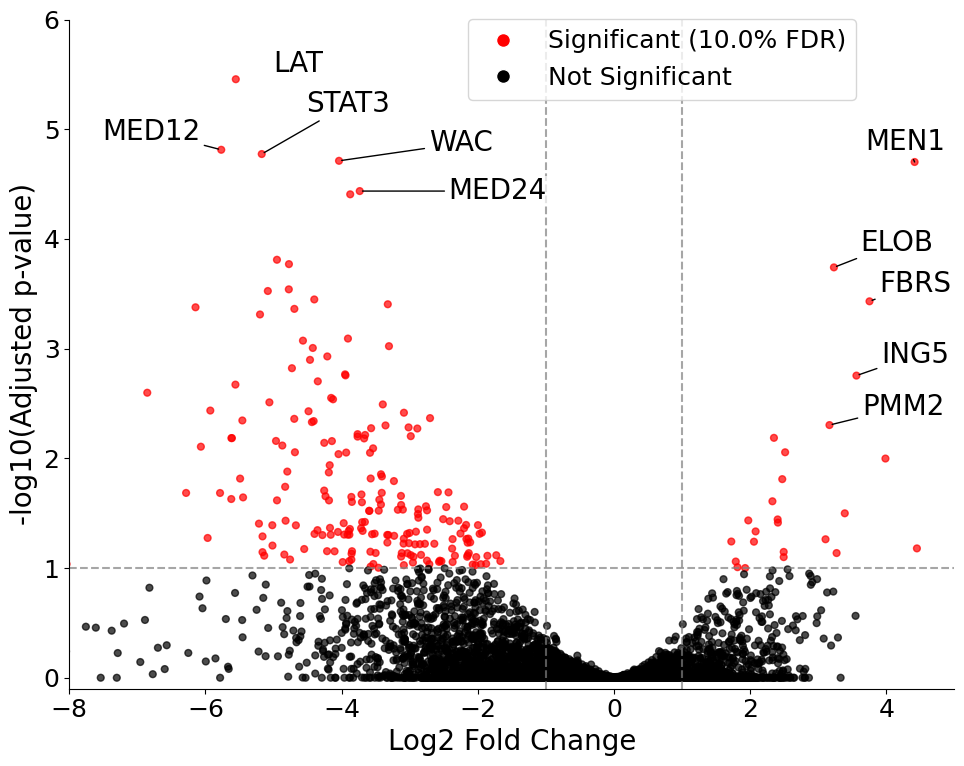

In [302]:
downstream_gene = 'IL10'
condition = 'Stim8hr'
significance_threshold = 0.1
log_fc_threshold = 1
top_n_genes = 5

plt.figure(figsize=(10,8))

pl_df = get_DE_results_long(adata_de, genes=[downstream_gene])
pl_df = pl_df[pl_df['culture_condition'] == condition]

# Calculate -log10(adj_p_value) for y-axis
pl_df['-log10_adj_p_value'] = -np.log10(pl_df['adj_p_value'])

# Set a threshold for significance
pl_df['significant'] = pl_df['adj_p_value'] < significance_threshold

# Create the scatter plot
scatter = plt.scatter(
    pl_df['log_fc'], 
    pl_df['-log10_adj_p_value'],
    c=pl_df['significant'].map({True: 'red', False: 'black'}),
    alpha=0.7,
    s=24
)

# Add labels for the most significant genes
texts = []
#top_genes = pl_df.nlargest(top_n_genes, '-log10_adj_p_value')
top_genes = pd.concat([pl_df[pl_df.zscore>0].nlargest(top_n_genes, '-log10_adj_p_value'), pl_df[pl_df.zscore<0].nlargest(top_n_genes, '-log10_adj_p_value')])
#top_genes = pd.concat([top_genes, pl_df[pl_df.target_contrast_gene_name=='ARRDC4']])
for _, gene in top_genes.iterrows():
    txt = plt.text(
        gene['log_fc'], 
        gene['-log10_adj_p_value'],
        gene['target_contrast_gene_name'],
        fontsize=20,
        ha='center',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )
    texts.append(txt)

adjustText.adjust_text(texts, force_pull=(0.02,0.02), arrowprops={"arrowstyle": "-", "color": "k", "zorder": 5})

# Add horizontal line for significance threshold
plt.axhline(y=-np.log10(significance_threshold), color='gray', linestyle='--', alpha=0.7)
# Add vertical lines for log fold change thresholds
plt.axvline(x=-log_fc_threshold, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=log_fc_threshold, color='gray', linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Log2 Fold Change', fontsize=20)
plt.ylabel('-log10(Adjusted p-value)', fontsize=20)
plt.xlim([-8, 5])
plt.ylim([-0.1, 6])

# Add legend outside the plot
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=f'Significant ({significance_threshold*100}% FDR)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Not Significant')
], loc=[0.45, 0.88], fontsize=18)

sns.despine()

plt.tight_layout()
plt.savefig('results/example_volcanoIL10.png')

In [239]:
pl_df

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
0,ENSG00000000003_Rest,ENSG00000109471,-0.439736,-0.818166,0.999953,False,IL2,Rest,ENSG00000000003,TSPAN6
1,ENSG00000000003_Stim48hr,ENSG00000109471,-0.952857,-1.057056,0.999804,False,IL2,Stim48hr,ENSG00000000003,TSPAN6
2,ENSG00000000003_Stim8hr,ENSG00000109471,-0.224881,-0.392318,0.999999,False,IL2,Stim8hr,ENSG00000000003,TSPAN6
3,ENSG00000000419_Rest,ENSG00000109471,-0.631462,-1.128998,0.691020,False,IL2,Rest,ENSG00000000419,DPM1
4,ENSG00000000419_Stim48hr,ENSG00000109471,-1.868897,-2.054642,0.886981,False,IL2,Stim48hr,ENSG00000000419,DPM1
...,...,...,...,...,...,...,...,...,...,...
33978,MTRNR2L8_Stim48hr,ENSG00000109471,3.336080,3.467912,0.678423,False,IL2,Stim48hr,ENSG00000255823,MTRNR2L8
33979,MTRNR2L8_Stim8hr,ENSG00000109471,0.522683,0.722188,0.999904,False,IL2,Stim8hr,ENSG00000255823,MTRNR2L8
33980,OCLM_Rest,ENSG00000109471,-0.732540,-1.306748,0.999981,False,IL2,Rest,OCLM,OCLM
33981,OCLM_Stim48hr,ENSG00000109471,-0.514819,-0.601078,1.000000,False,IL2,Stim48hr,OCLM,OCLM


In [236]:
test_df[test_df.adj_p_value<0.1]

,index,gene,log_fc,adj_p_value,significant,gene_name,culture_condition,target_contrast_gene_name,-log10_adj_p_value
9121,ENSG00000109471_Stim8hr,ENSG00000109471,-3.469852,0.000024,True,IL2,Stim8hr,IL2,4.621287
14461,ENSG00000109471_Stim8hr,ENSG00000127318,-4.429746,0.090358,True,IL22,Stim8hr,IL2,1.044033
